In [ ]:
# import gdown

# # Replace 'file_id' with the actual file ID you want to download
# file_id = '17_boNLEhV6G0jwANXgjm6FClGLoMYmYI'

# # Replace 'output' with the desired output file name
# output = 'blob'
# # Use the gdown.download method to download the file
# gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)


# check


In [ ]:
# import zipfile

# # Path to the zip file
# zip_file_path = "blob"

# # Directory where you want to extract the contents
# extract_to_directory = "extracted_files"

# # Open the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # Extract all the contents to the specified directory
#     zip_ref.extractall(extract_to_directory)

# print("Extraction complete.")

# check

In [1]:
import time

def loading_time_calculator(dataloader):
    t1 = time.time()
    print("hello ",t1)
    for data in dataloader:
        # print(data)
        pass

    t2 = time.time()
    # print("hello2 ", t2)

    return t2 - t1

# check

In [2]:
import os
import csv
import numpy as np

class CustomDataset:
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.data = self.load_dataset()

    def load_dataset(self):
        dataset = []
        with open(self.csv_file, 'r') as file:
            csv_reader = csv.reader(file)
            header = next(csv_reader)  # Skip the header row
            for row in csv_reader:
                label = int(row[0])
                pixel_values = np.array([int(value) for value in row[1:]], dtype=np.uint8)
                image = pixel_values.reshape((28, 28))  # Assuming MNIST image dimensions are 28x28
                dataset.append((image, label))
        return dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image, label

# Example usage
csv_train_path = 'extracted_files/mnist_train.csv'
csv_test_path = 'extracted_files/mnist_test.csv'
custom_dataset = CustomDataset(csv_train_path)
test_data_custom = CustomDataset(csv_test_path)

# check

In [3]:
from sklearn.model_selection import train_test_split
print(custom_dataset[0])

train_data_custom, val_data_custom = train_test_split(custom_dataset, test_size=0.1, random_state=42)

# check

(array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [ 

In [4]:
# import os
# from PIL import Image
# import numpy as np
# from sklearn.model_selection import train_test_split

# class CustomDataset:
#     def __init__(self, root_dir):
#         self.root_dir = root_dir
#         self.data = self.load_dataset()

#     def load_dataset(self):
#         dataset = []
#         for digit in os.listdir(self.root_dir):
#             digit_path = os.path.join(self.root_dir, digit)
#             for image_file in os.listdir(digit_path):
#                 image_path = os.path.join(digit_path, image_file)
#                 label = int(digit)
#                 dataset.append((image_path, label))
#         return dataset

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         img_path, label = self.data[idx]
#         image = np.array(Image.open(img_path))
#         return image, label

# # Example usage:
# root_dir = 'extracted_files/'
# custom_dataset = CustomDataset(root_dir)
# train_data_custom, val_data_custom = train_test_split(custom_dataset, test_size=0.1, random_state=42)

# Print the number of samples in the dataset
print(len(custom_dataset))
print(len(train_data_custom))
print(len(val_data_custom))
print(len(test_data_custom))

# Access a sample from the dataset
sample_image, sample_label = custom_dataset[0]
print(f"Label: {sample_label}, Image Shape: {sample_image.shape}")


60000
54000
6000
10000
Label: 5, Image Shape: (28, 28)


In [5]:
class CustomDataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = list(range(len(dataset)))
        self.current_index = 0

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_index >= len(self.indices):
            raise StopIteration

        batch_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        batch_data = [self.dataset[i] for i in batch_indices]

        self.current_index += self.batch_size

        images, labels = zip(*batch_data)
        return np.array(images), np.array(labels)


In [6]:
batch_sizes = [128, 256, 512, 1024]

In [7]:
custom_time=[]
for i in batch_sizes:
    custom_dataloader = CustomDataLoader(custom_dataset, i)
    duration = loading_time_calculator(custom_dataloader)
    custom_time.append(duration)

print(custom_time)
# for i in range(0, len(custom_dataset), batch_size):
#     batch_data = custom_dataset[i:i+batch_size]
    # Process the batch as needed


hello  1706977213.9948514
hello  1706977214.1648467
hello  1706977214.2766414
hello  1706977214.3596451
[0.13899946212768555, 0.1087944507598877, 0.08008289337158203, 0.08099603652954102]


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TorchDataset(Dataset):
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.data = self.load_dataset()

    def load_dataset(self):
        dataset = []
        with open(self.csv_file, 'r') as file:
            csv_reader = csv.reader(file)
            header = next(csv_reader)  # Skip the header row
            for row in csv_reader:
                label = int(row[0])
                pixel_values = np.array([int(value) for value in row[1:]], dtype=np.uint8)
                image = pixel_values.reshape((28, 28))  # Assuming MNIST image dimensions are 28x28
                dataset.append((torch.tensor(image, dtype=torch.float32), label))
        return dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        # Add channel dimension as torchvision expects (C, H, W)
        image = image.unsqueeze(0)
        return image, label

# Example usage
csv_file_path = 'extracted_files/mnist_train.csv'
torch_dataset = TorchDataset(csv_file_path)

# Apply transforms similar to the ImageFolder dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

# Wrap your custom dataset in a DataLoader
# train_loader = DataLoader(dataset=custom_dataset, batch_size=32, shuffle=True)


In [ ]:
# from torchvision import transforms, datasets
# from torch.utils.data import DataLoader

# transform = transforms.Compose([
#     transforms.ToTensor()
# ])

# train_dataset = datasets.ImageFolder(root='extracted_folder/MNIST_DATASET/trainingSet/trainingSet', transform=transform)
# # train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4)


In [9]:
# time2 = loading_time_calculator(train_loader)

torch_time = []
for i in batch_sizes:
    torch_dataloader = DataLoader(dataset=torch_dataset, batch_size=i, shuffle=True)
    duration = loading_time_calculator(torch_dataloader)
    print(duration)
    torch_time.append(duration)

# print(time2)

hello  1706977268.2390475
0.353039026260376
hello  1706977268.5930867
0.3149991035461426
hello  1706977268.9090867
0.3815772533416748
hello  1706977269.290664
0.49593305587768555


In [10]:
print(torch_time)

[0.353039026260376, 0.3149991035461426, 0.3815772533416748, 0.49593305587768555]


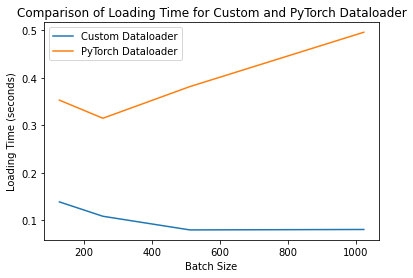

In [11]:
import matplotlib.pyplot as plt
plt.plot(batch_sizes, custom_time, label='Custom Dataloader')
plt.plot(batch_sizes, torch_time, label='PyTorch Dataloader')
plt.xlabel('Batch Size')
plt.ylabel('Loading Time (seconds)')
plt.title('Comparison of Loading Time for Custom and PyTorch Dataloader')
plt.legend()
plt.show()

In [12]:
custom_dataloader = CustomDataLoader(custom_dataset, 512)

In [13]:
custom_dataset[0]

(array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
           0

In [ ]:
# train_dataset[0]

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Feed-Forward neural network architecture
class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 10)  # Output layer with 10 classes (assuming MNIST dataset)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Instantiate the model, loss function, and optimizer
model = FeedForwardNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0003)

# Training loop
  # You can adjust this as needed


In [17]:
num_epochs = 60
epoch_list=list(range(1, 61))
train_loss_list=[]
validation_loss_list=[]
test_loss_list=[]

train_accuracy_list=[]
validation_accuracy_list=[]
test_accuracy_list=[]

for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    # print("hello epoch")
    custom_dataloader = CustomDataLoader(train_data_custom, 512)
    for inputs, labels in custom_dataloader:
        # print("hello data")
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)

        total_correct += (predicted == labels).sum().item()

        total_samples += labels.size(0)

    # print("epoch end")
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
    train_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Training Set: {accuracy}')
    train_accuracy_list.append(accuracy)

    total_correct = 0
    total_samples = 0

    validation_dataloader = CustomDataLoader(val_data_custom, 512)
    for inputs, labels in validation_dataloader:
        # print("hello data")
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)

        total_correct += (predicted == labels).sum().item()

        total_samples += labels.size(0)

    # print("epoch end")
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {loss.item()}')
    validation_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Validation Set: {accuracy}')
    validation_accuracy_list.append(accuracy)


    total_correct = 0
    total_samples = 0

    test_dataloader = CustomDataLoader(test_data_custom, 512)
    for inputs, labels in test_dataloader:
        # print("hello data")
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)

        total_correct += (predicted == labels).sum().item()

        total_samples += labels.size(0)

    # print("epoch end")
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {loss.item()}')
    test_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Test Set: {accuracy}')
    test_accuracy_list.append(accuracy)



# After training, you can use the model for predictions
# Example:
# test_inputs, test_labels = next(iter(test_dataloader))
# test_inputs = torch.from_numpy(test_inputs).float()
# predictions = model(test_inputs)


Epoch [1/60], Loss: 2.1240146160125732
Epoch 0, Accuracy on Training Set: 0.16914814814814816
Epoch [1/60], Validation Loss: 2.1391382217407227
Epoch 0, Accuracy on Validation Set: 0.22133333333333333
Epoch [1/60], Test Loss: 2.1519651412963867
Epoch 0, Accuracy on Test Set: 0.2356
Epoch [2/60], Loss: 1.9209555387496948
Epoch 1, Accuracy on Training Set: 0.28305555555555556
Epoch [2/60], Validation Loss: 1.8415248394012451
Epoch 1, Accuracy on Validation Set: 0.3601666666666667
Epoch [2/60], Test Loss: 1.9028277397155762
Epoch 1, Accuracy on Test Set: 0.3696
Epoch [3/60], Loss: 1.6174066066741943
Epoch 2, Accuracy on Training Set: 0.41409259259259257
Epoch [3/60], Validation Loss: 1.5595178604125977
Epoch 2, Accuracy on Validation Set: 0.47433333333333333
Epoch [3/60], Test Loss: 1.5713237524032593
Epoch 2, Accuracy on Test Set: 0.4798
Epoch [4/60], Loss: 1.3649433851242065
Epoch 3, Accuracy on Training Set: 0.5126481481481482
Epoch [4/60], Validation Loss: 1.4281725883483887
Epoch 3, 

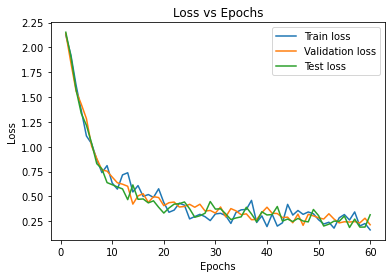

In [18]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_loss_list, label='Train loss')
plt.plot(epoch_list, validation_loss_list, label='Validation loss')
plt.plot(epoch_list, test_loss_list, label='Test loss')
# plt.plot(batch_sizes, torch_time, label='PyTorch Dataloader')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

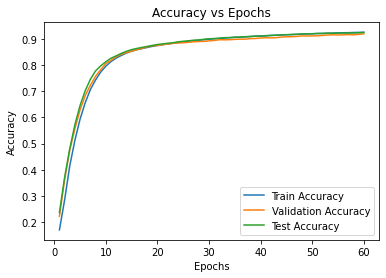

In [19]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_accuracy_list, label='Train Accuracy')
plt.plot(epoch_list, validation_accuracy_list, label='Validation Accuracy')
plt.plot(epoch_list, test_accuracy_list, label='Test Accuracy')
# plt.plot(batch_sizes, torch_time, label='PyTorch Dataloader')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()